<a href="https://colab.research.google.com/github/sambhav-antriksh/AIML-Project/blob/main/Fourier_Neural_Operator_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fourier Neural Opertors (FNO) in JAX**
we would use Equinox and Optax.

In [1]:
%pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.5 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy

In [3]:
# The Dataset
# Mathworks (the creators of Matlab) host the original Li et al. Dataset in the .mat format
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2025-10-08 10:17:41--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.196.156.41
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.196.156.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  85.0MB/s    in 6.3s    

2025-10-08 10:17:48 (97.8 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [4]:
data=scipy.io.loadmat('burgers_data_R10.mat')

In [5]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])

In [6]:
a, u = data['a'],data['u']  # a is the initial 1D function and u is the 1D function at t=1

In [7]:
a.shape,u.shape    # these shapes indicate that there are 2048 samples available for 8192 discrete points

((2048, 8192), (2048, 8192))

In [8]:
a.shape

(2048, 8192)

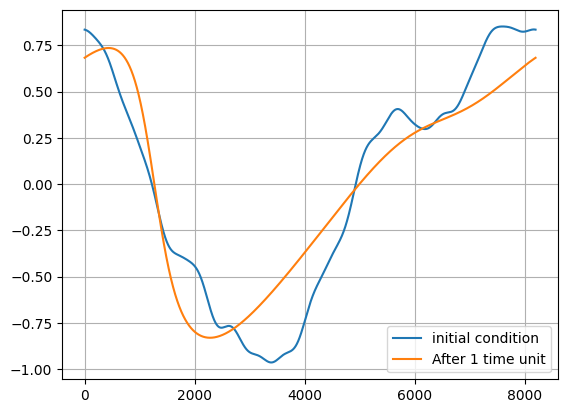

In [9]:
plt.plot(a[0],label='initial condition')
plt.plot(u[0],label='After 1 time unit')
plt.legend()
plt.grid()

In the above curve we see one sample at t=0 and t=1. This is like advection also, in which the negative solution moves to the left and the positive solution moves to the right with smoothening.

# Learn the mapping between the orange to blue one, from the 2048 samples that we have

We are adding the channel dimension because the Fourier Neural Operator (FNO) , like CNN expects the data to be in the format
Input shape: [batch, channels, grid_points]


In [10]:
# Add channel dimension
a=a[:,jnp.newaxis,:]
u= u[:,jnp.newaxis, :]

In [11]:
a.shape,u.shape

((2048, 1, 8192), (2048, 1, 8192))

In [12]:
# Mesh is from 0 to 2*pi
mesh=jnp.linspace(0,2*jnp.pi,u.shape[-1])
mesh.shape

(8192,)

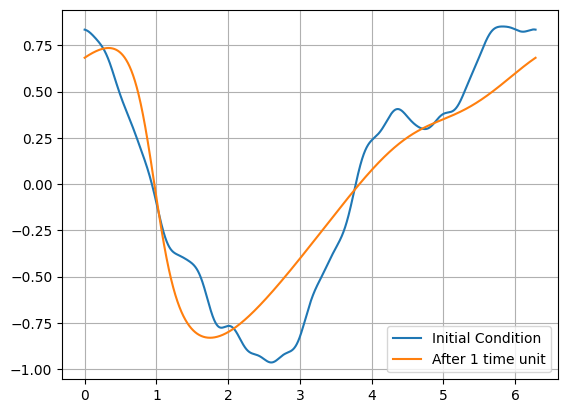

In [13]:
plt.plot(mesh,a[0][0],label='Initial Condition')
plt.plot(mesh,u[0,0],label='After 1 time unit')
plt.legend()
plt.grid()

Each sample has to be repeated over same mesh.

In [14]:
mesh_shape_corrected=jnp.repeat(mesh[jnp.newaxis,jnp.newaxis,:],u.shape[0],axis=0)
a_with_mesh=jnp.concatenate((a,mesh_shape_corrected),axis=1)
# this line of code is important because now we have (2048,2,8192)--> channel 0 gives the function value at every x
# and channel 1 gives the mesh grid


In [15]:
a_with_mesh.shape,mesh_shape_corrected.shape,mesh_shape_corrected[0,0]

((2048, 2, 8192),
 (2048, 1, 8192),
 Array([0.0000000e+00, 7.6708401e-04, 1.5341680e-03, ..., 6.2816510e+00,
        6.2824183e+00, 6.2831855e+00], dtype=float32))

In [16]:
train_x=a_with_mesh[:1000]
test_x=a_with_mesh[1000:1200]
train_y=u[:1000]
test_y=u[1000:1200]

## Building FNO

In [17]:
class SpectralConv1d(eqx.Module):  #this class is inside the eqx.Module class
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int
    def __init__(self,in_channels,out_channels,modes,*,key,):
      self.in_channels=in_channels
      self.out_channels=out_channels
      self.modes=modes

      scale=1.0/(in_channels*out_channels)
      real_key,imag_key=jax.random.split(key)
      self.real_weights=jax.random.uniform(
          real_key,(in_channels,out_channels,modes),
          minval=-scale,
          maxval=+scale,)
      self.imag_weights=jax.random.uniform(
          imag_key,(in_channels,out_channels,modes),
          minval=-scale,
          maxval=+scale,)

    def complex_mult1d(self,x_hat,w,):
        return jnp.einsum('iM,ioM->oM',x_hat,w)
      # Forward Pass
    def __call__(self,x,):
        channels,spatial_points=x.shape

        x_hat=jnp.fft.rfft(x,axis=-1)
          # shape of x_hat is (in_channels,spatial_points//2+1)

        x_hat_under_modes=x_hat[:,:self.modes]
          # shape of x_hat_under_modes is (in_channels,self.modes)
        weights= self.real_weights + 1j * self.imag_weights
          # shape of out_hat_under_modes is (out_channels,self.modes)
        out_hat_under_modes= self.complex_mult1d(x_hat_under_modes,weights)
          # shape of out_hat is (out_channels,spatial_points//2+1)
        out_hat=jnp.zeros((self.out_channels,x_hat.shape[-1]),dtype=x_hat.dtype)
        out_hat=out_hat.at[:,:self.modes].set(out_hat_under_modes)

        out=jnp.fft.irfft(out_hat,n=spatial_points)

        return out


In [ ]:
class FNOBlock1d(eqx.Module):
  spectral_conv: SpectralConv1d
  bypass_conv: eqx.nn.Conv1d
  activation : Callable

  def __init__(self,in_channels,out_channels,modes,activation,*,key,):
    spectral_conv_key,bypass_conv_key=jax.random.split(key)
    self.spectral_conv= SpectralConv1d(in_channels,out_channels,modes,key=spectral_conv_key,)
    self.bypass_conv= eqx.nn.Conv1d(in_channels,out_channels,1,key=bypass_conv_key,)  #kernel size is 1
    self.activation=activation

  def __call__(self,x,):
      return self.activation(self.spectral_conv(x)+self.bypass_conv(x))

In [ ]:
class FNO1D(eqx.Module):
  lifting: eqx.nn.Conv1d
  fno_blocks: List[FNOBlock1d]
  projection: eqx.nn.Conv1d

  def __init__(self,in_channels,out_channels,modes,width,activation,n_blocks=4,*,key,):
      key,lifting_key=jax.random.split(key)
      self.lifting=eqx.nn.Conv1d(in_channels,width,1,key=lifting_key)

      self.fno_blocks=[]
      for i in range(n_blocks):
          key,subkey = jax.random.split(key)
          self.fno_blocks.append(FNOBlock1d(width,width,modes,activation,key=subkey,))

      key,projection_key=jax.random.split(key)

      self.projection=eqx.nn.Conv1d(width,out_channels,1,key=projection_key,)


  def __call__(self,x,):
      x=self.lifting(x)

      for fno_block in self.fno_blocks:
          x=fno_block(x)

      x=self.projection(x)

      return x

In [ ]:
fno=FNO1D(
    2,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
    )

In [ ]:
def dataloader(key,dataset_x,dataset_y,batch_size,):
    n_samples=dataset_x.shape[0]
    n_batches= int(jnp.ceil(n_samples/batch_size))

    permutation= jax.random.permutation(key,n_samples)

    for batch_id in range(n_batches):
        start=batch_id*batch_size
        end=min((batch_id+1)*batch_size,n_samples)

        batch_idx= permutation[start:end]

        yield dataset_x[batch_idx],dataset_y[batch_idx]

